In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", 
    message="You passed a edgecolor/edgecolors.*", 
    category=UserWarning)

In [80]:
path = r"F:\SUST Research Project\GCM\ACCESS ESM 1 5\Precipitation\Historical\Historical CSV"
data_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]

In [81]:
data_arr = []
for i in data_path:
    data_arr.append(pd.read_csv(i, index_col=0, parse_dates=True))

In [82]:
for df in data_arr:
    df.dropna(inplace=True)
    df['historical'] = df['historical'] * 86400

In [83]:
data_arr[0].head()

,Precipitation,district,station_id,lat,lon,historical
Date,,,,,,
1978-12-01,0.0,Barisal,1.0,22.716667,90.366667,0.115931
1979-01-01,1.0,Barisal,1.0,22.716667,90.366667,0.157278
1979-02-01,14.0,Barisal,1.0,22.716667,90.366667,1.902250
1979-03-01,30.0,Barisal,1.0,22.716667,90.366667,1.640382
1979-04-01,38.0,Barisal,1.0,22.716667,90.366667,0.218333


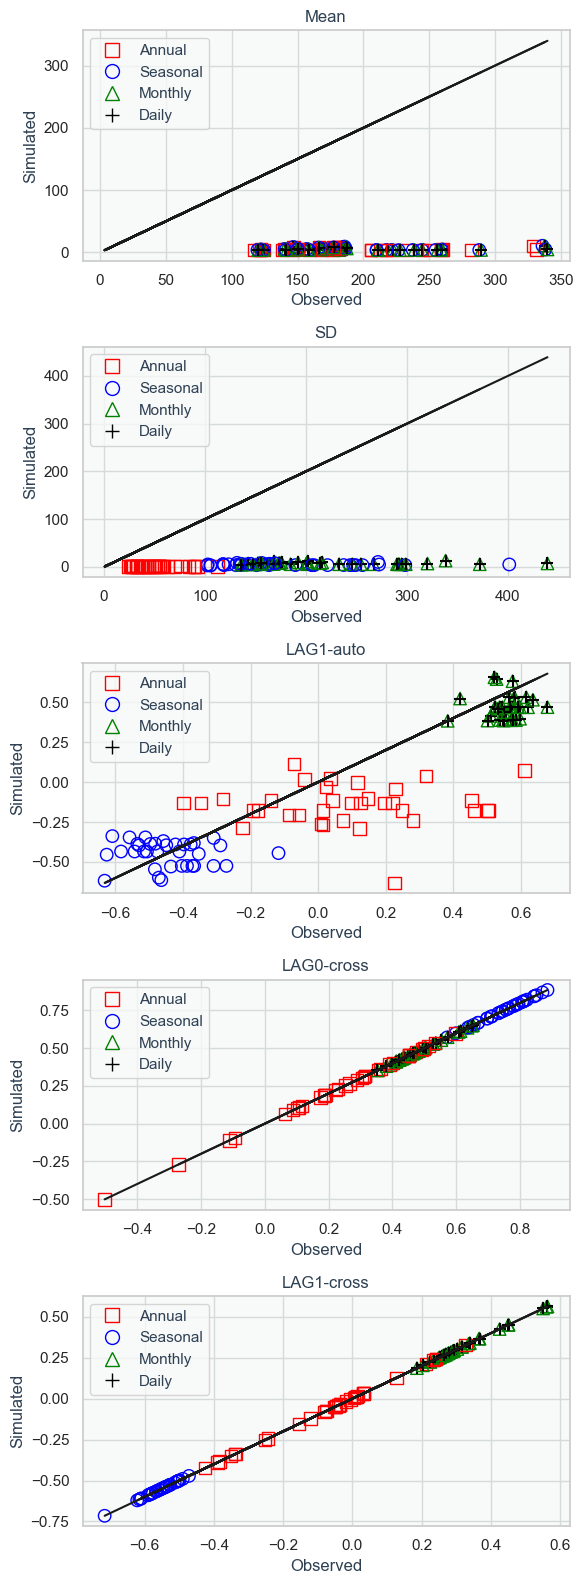

In [84]:
# Define function to assign seasons
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

# Aggregation levels
def aggregate(series, freq):
    if freq == 'Seasonal':
        return series.groupby([series.index.year, series.index.month.map(get_season)]).mean()
    elif freq == 'Annual':
        return series.resample('YS').mean()
    elif freq == 'Monthly':
        return series.resample('MS').mean()
    elif freq == 'Daily':
        return series
    else:
        raise ValueError("Unsupported frequency")

frequencies = ['Annual', 'Seasonal', 'Monthly', 'Daily']
colors = ['red', 'blue', 'green', 'black']
markers = ['s', 'o', '^', '+']
labels = ['Annual', 'Seasonal', 'Monthly', 'Daily']

# Compute statistics for each temporal scale
def compute_stats(obs, sim):
    return {
        'Mean': (obs.mean(), sim.mean()),
        'SD': (obs.std(), sim.std()),
        'LAG1-auto': (obs.autocorr(lag=1), sim.autocorr(lag=1)),
        'LAG0-cross': (np.corrcoef(obs, sim)[0, 1], np.corrcoef(obs, sim)[0, 1]),
        'LAG1-cross': (np.corrcoef(obs[1:], sim[:-1])[0, 1], np.corrcoef(obs[1:], sim[:-1])[0, 1]),
    }

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(6, 16))

# Plot all data with corrected marker styling
for df in data_arr:
    observed = df['Precipitation']
    simulated = df['historical']

    results = {'Mean': [], 'SD': [], 'LAG1-auto': [], 'LAG0-cross': [], 'LAG1-cross': []}

    for freq in frequencies:
        obs_agg = aggregate(observed, freq)
        sim_agg = aggregate(simulated, freq)
        stats = compute_stats(obs_agg, sim_agg)
        for key in results:
            results[key].append(stats[key])

    stat_names = ['Mean', 'SD', 'LAG1-auto', 'LAG0-cross', 'LAG1-cross']

    for i, stat in enumerate(stat_names):
        ax = axs[i]
        obs_vals = [x[0] for x in results[stat]]
        sim_vals = [x[1] for x in results[stat]]
        for j in range(len(frequencies)):
            # Corrected marker styling
            ax.scatter(
                obs_vals[j], sim_vals[j],
                marker=markers[j],
                edgecolor=colors[j],  # Always use color for edges
                facecolor='none' if markers[j] in ['s', 'o', '^'] else colors[j],  # Hollow for filled markers
                s=80
            )

        # Plot 45-degree diagonal (unchanged)
        min_val = min(min(obs_vals), min(sim_vals))
        max_val = max(max(obs_vals), max(sim_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'k-')

        ax.set_xlabel('Observed')
        ax.set_ylabel('Simulated')
        ax.set_title(stat)

# Create legend handles with corrected styling
handles = [
    plt.Line2D([], [],
               marker=markers[j],
               color=colors[j],
               markersize=10,
               markeredgecolor=colors[j],
               markerfacecolor='none' if markers[j] in ['s', 'o', '^'] else colors[j],
               linestyle='None',
               label=labels[j])
    for j in range(len(frequencies))
]

# Add legend to each subplot
for ax in axs:
    ax.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

In [85]:
data_arr[0].describe()

,Precipitation,station_id,lat,lon,historical
count,433.000000,433.0,4.330000e+02,4.330000e+02,433.000000
mean,172.565820,1.0,2.271667e+01,9.036667e+01,3.607952
std,184.844444,0.0,1.102615e-13,4.125915e-13,5.827481
min,0.000000,1.0,2.271667e+01,9.036667e+01,0.004799
25%,11.000000,1.0,2.271667e+01,9.036667e+01,0.295888
50%,112.000000,1.0,2.271667e+01,9.036667e+01,0.995306
75%,280.000000,1.0,2.271667e+01,9.036667e+01,3.863851
max,1067.000000,1.0,2.271667e+01,9.036667e+01,34.040682


In [122]:
def standardize_by_month(series):
    """
    Standardizes the values in the series by subtracting the monthly mean 
    and dividing by the monthly standard deviation.

    Args:
        series (pd.Series): A pandas Series with a datetime index.

    Returns:
        pd.Series: A pandas Series of standardized values.
    """
    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series.")

    if not pd.api.types.is_datetime64_any_dtype(series.index):
        raise ValueError("The Series must have a datetime index.")

    # Group by month and calculate mean and standard deviation
    monthly_mean = series.groupby(series.index.month).mean()
    monthly_std = series.groupby(series.index.month).std()

    # Standardize the values using the monthly mean and standard deviation
    # Replace 0 with NaN to avoid division by zero
    standardized_values = (
        series - series.index.month.map(monthly_mean)) / series.index.month.map(monthly_std)
    # Fill NaN values with 0
    return standardized_values


def destandardize_by_month(standardized_values, original_series):
    """
    Reverses the standardization process to get back the original values.

    Args:
        standardized_values (pd.Series): The standardized values.
        original_series (pd.Series): Original series used for standardization (provides mean and std).

    Returns:
        pd.Series: The destandardized values.
    """
    if not isinstance(standardized_values, pd.Series) or not isinstance(original_series, pd.Series):
        raise ValueError("Both inputs must be pandas Series.")

    if not pd.api.types.is_datetime64_any_dtype(original_series.index):
        raise ValueError("The Series must have a datetime index.")

    # Group by month and calculate mean and standard deviation
    monthly_mean = original_series.groupby(original_series.index.month).mean()
    monthly_std = original_series.groupby(original_series.index.month).std()

    # Destandardize the values using the monthly mean and standard deviation
    destandardized_values = (standardized_values * standardized_values.index.month.map(
        monthly_std)) + standardized_values.index.month.map(monthly_mean)

    return destandardized_values
def monthly_bias_correction(y_observed, y_predicted, variable_name="monthly_bias_corrected"):
    """
    Corrects biases in the predicted values using the monthly bias correction (MBC) method. 

    Note: Series must contain a DatetimeIndex.
    Reference: https://doi.org/10.1061/(ASCE)HE.1943-5584.0000585
               https://doi.org/10.1029/2011WR010464

    Args:
        y_observed (pandas.Series): Observed values of the variable with a DatetimeIndex.
        y_predicted (pandas.Series): Predicted values of the variable with a DatetimeIndex.
        variable_name (str, optional): Name for the corrected series. Defaults to "nested_bias_corrected".

    Returns:
        pandas.Series: Bias-corrected predicted values.
    """

    # Step 1: Standardize the predicted series by month
    # ==================================================
    y_prime = standardize_by_month(y_predicted)

    # Step 2: Destandardize the series by month using observed values
    # ================================================================
    y_corrected = destandardize_by_month(y_prime, y_observed)

    return y_corrected.rename(variable_name)

def nested_bias_correction(y_observed, y_predicted, variable_name="nested_bias_corrected"):
    """
    Corrects biases in the predicted values using the nested bias correction (NBC) method. 

    Note: Series must contain a DatetimeIndex.
    Reference: https://doi.org/10.1061/(ASCE)HE.1943-5584.0000585
               https://doi.org/10.1029/2011WR010464

    Args:
        y_observed (pandas.Series): Observed values of the variable with a DatetimeIndex.
        y_predicted (pandas.Series): Predicted values of the variable with a DatetimeIndex.
        variable_name (str, optional): Name for the corrected series. Defaults to "nested_bias_corrected".

    Returns:
        pandas.Series: Bias-corrected predicted values.
    """

    # Step 1: Standardize the modelled monthly series by month
    # ========================================================
    y_prime = standardize_by_month(y_predicted)

    # Step 2: Monthly lag 1 autocorrelation correction
    # ================================================
    # Autocorrelation between two consecutive month (January , February) and (February, March) and so on
    temp = pd.DataFrame({
        'current': y_predicted,
        'lagged': y_predicted.shift(1)
    })

    rho_predicted = temp.groupby(temp.index.month).apply(
        lambda x: x['current'].corr(x['lagged'])
    )

    temp = pd.DataFrame({
        'current': y_observed,
        'lagged': y_observed.shift(1)
    })

    rho_observed = temp.groupby(temp.index.month).apply(
        lambda x: x['current'].corr(x['lagged'])
    )

    del temp

    unique_years = sorted(y_prime.index.year.unique(), reverse=True)
    unique_months = sorted(y_prime.index.month.unique(), reverse=True)

    # Initialized an empty series to store y_two_prime data
    y_two_prime = pd.Series(
        np.array(np.nan) * len(y_prime), index=y_prime.index)

    # returns an array of single value array([0.86417553])
    def y_two_prime_i_k(month, year):
        # Get current month's data
        y_prime_i_k = y_prime[(y_prime.index.month == month)
                              & (y_prime.index.year == year)]

        # If reached the base January of the starting year return the value of that month
        if (month == 1) and (year == min(unique_years)):
            return y_prime_i_k.values
        # If reached the January of a year use December of previous year to correct January
        if month == 1:
            y_prime_i_minus_one_k = y_prime[(y_prime.index.month == (
                12)) & (y_prime.index.year == year-1)]

            rest = np.sqrt(1 - (rho_observed[month]) ** 2) * (
                (y_prime_i_k.values - rho_predicted[month] * y_prime_i_minus_one_k.values) /
                np.sqrt(1 - (rho_predicted[month]) ** 2)
            )
            # Calculate y"_i_k for a given year which corrects monthly biases
            return rho_observed[month] * y_two_prime_i_k(12, year - 1) + rest

        else:
            # Get previous month's data y'_(i-1)
            y_prime_i_minus_one_k = y_prime[(y_prime.index.month == (
                month - 1)) & (y_prime.index.year == year)]
            # Calculate the corrected value
            rest = np.sqrt(1 - (rho_observed[month]) ** 2) * (
                (y_prime_i_k.values - rho_predicted[month] * y_prime_i_minus_one_k.values) /
                np.sqrt(1 - (rho_predicted[month]) ** 2)
            )
            # Calculate y"_i_k for a given year which corrects monthly biases
            return rho_observed[month] * y_two_prime_i_k(month - 1, year) + rest

    for year in unique_years:
        for month in unique_months:
            y_two_prime.loc[(y_two_prime.index.month == month) & (
                y_two_prime.index.year == year)] = y_two_prime_i_k(month, year)[0] if y_two_prime_i_k(month, year).size > 0 else y_prime.loc[(y_prime.index.month == month) & (y_prime.index.year == year)]  # If any data is missing enter 0, occurs if any data from previous month is missing.

    # Step 3: Rescale the series using observed means and stds
    # ========================================================
    y_three_prime = destandardize_by_month(y_two_prime, y_observed)
    # Set negative values to zero
    y_three_prime[y_three_prime < 0] = 0

    # Step 4: Standardize the annual series
    # =====================================
    z_k = y_three_prime.resample('YS').mean()
    z_prime = (z_k - z_k.mean())/z_k.std()

    # Step 5: Yearly lag 1 autocorrelation correction
    # ================================================
    rho_predicted = y_predicted.resample('YS').mean().autocorr(lag=1)
    rho_observed = y_observed.resample('YS').mean().autocorr(lag=1)

    # Initialized an empty series to store z_two_prime data
    z_two_prime = pd.Series(
        np.array(np.nan) * len(z_prime), index=z_prime.index)

    # Nested iteration from last year to first year and last month to first month
    def z_two_prime_k(year):
        # Get current month's data
        z_prime_k = z_prime[z_prime.index.year == year]
        # Get previous month's data z_prime_k_minus_1
        z_prime_k_minus_one = z_prime[z_prime.index.year == (year-1)]

        if year == unique_years[-1]:
            # If it's Base-year, return current year's data
            return z_prime_k.values
        else:
            # Calculate the corrected value
            rest = np.sqrt(1 - (rho_observed) ** 2) * (
                (z_prime_k.values - rho_predicted * z_prime_k_minus_one.values) /
                np.sqrt(1 - (rho_predicted) ** 2)
            )
            # Calculate z"_k for a given year which corrects yearly biases
            # [2014, 2013, 2012, 2011, 2010] the below code returns unique_years[unique_years.index(2014) + 1]
            # output: 2013 // the index method returns the index of the current value in the array
            return rho_observed * z_two_prime_k(unique_years[unique_years.index(year) + 1]) + rest

    # Perform calculations
    for year in unique_years:
        # z_two_prime_k(year) returns an array of single value array([0.86417553])
        z_two_prime.loc[z_two_prime.index.year == year] = z_two_prime_k(year)[
            0]
    # resample the observed series by mean and find the mean and std of the resampled series
    z_three_prime = (z_two_prime * y_observed.resample('YS').mean().std()
                     ) + y_observed.resample('YS').mean().mean()
    # Set negative values to zero
    z_three_prime[z_three_prime < 0] = 0
    # Step 6: Apply yearly correction to the monthly corrected series
    # ===============================================================
    # transforms the index from 2014-01-01 to 2014 for mapping values
    z_ratio = (z_three_prime / z_k).groupby(z_k.index.year).mean()
    y_corrected = y_three_prime * y_three_prime.index.year.map(z_ratio)

    return y_corrected.rename(variable_name)

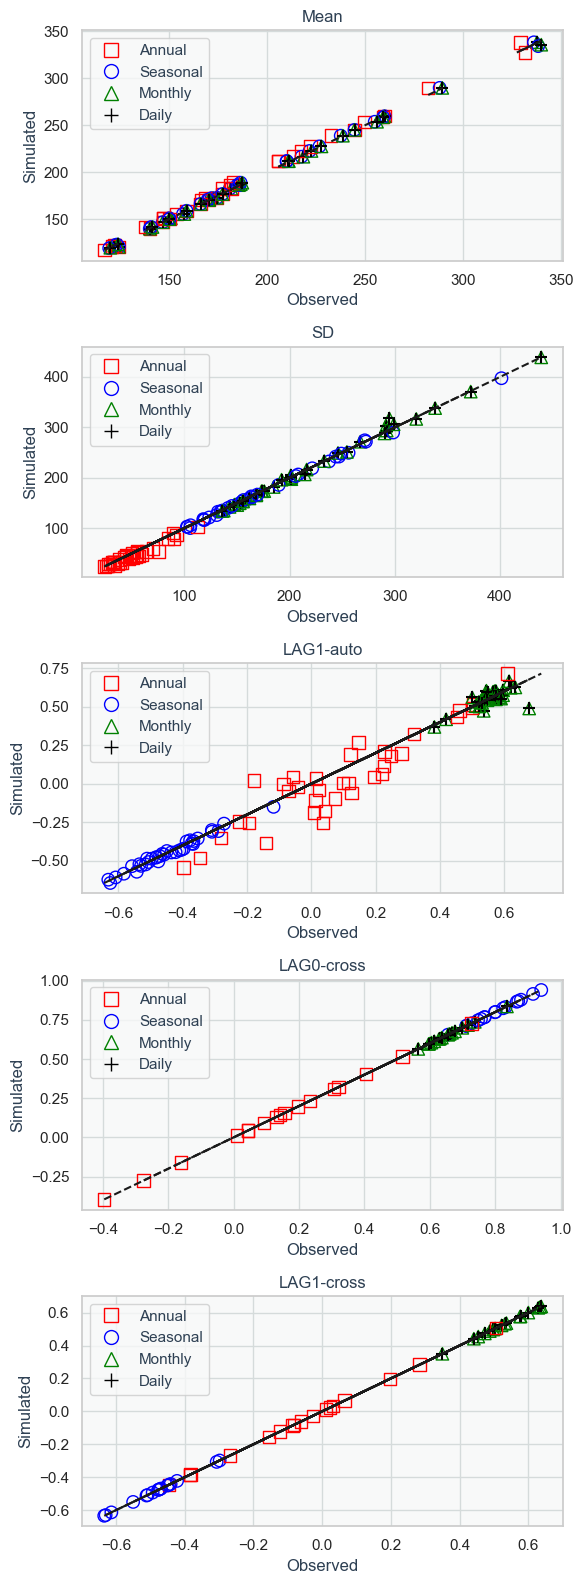

In [87]:
# Plotting
fig, axs = plt.subplots(5, 1, figsize=(6, 16))

# Plot all data with corrected marker styling
for df in data_arr:
    observed = df['Precipitation']
    simulated = nested_bias_correction(df['Precipitation'] , df['historical'])

    results = {'Mean': [], 'SD': [], 'LAG1-auto': [], 'LAG0-cross': [], 'LAG1-cross': []}

    for freq in frequencies:
        obs_agg = aggregate(observed, freq)
        sim_agg = aggregate(simulated, freq)
        stats = compute_stats(obs_agg, sim_agg)
        for key in results:
            results[key].append(stats[key])

    stat_names = ['Mean', 'SD', 'LAG1-auto', 'LAG0-cross', 'LAG1-cross']

    for i, stat in enumerate(stat_names):
        ax = axs[i]
        obs_vals = [x[0] for x in results[stat]]
        sim_vals = [x[1] for x in results[stat]]
        for j in range(len(frequencies)):
            # Corrected marker styling
            ax.scatter(
                obs_vals[j], sim_vals[j],
                marker=markers[j],
                edgecolor=colors[j],  # Always use color for edges
                facecolor='none' if markers[j] in ['s', 'o', '^'] else colors[j],  # Hollow for filled markers
                s=80
            )

        # Plot 45-degree diagonal (unchanged)
        min_val = min(min(obs_vals), min(sim_vals))
        max_val = max(max(obs_vals), max(sim_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'k--')

        ax.set_xlabel('Observed')
        ax.set_ylabel('Simulated')
        ax.set_title(stat)

# Create legend handles with corrected styling
handles = [
    plt.Line2D([], [],
               marker=markers[j],
               color=colors[j],
               markersize=10,
               markeredgecolor=colors[j],
               markerfacecolor='none' if markers[j] in ['s', 'o', '^'] else colors[j],
               linestyle='None',
               label=labels[j])
    for j in range(len(frequencies))
]

# Add legend to each subplot
for ax in axs:
    ax.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

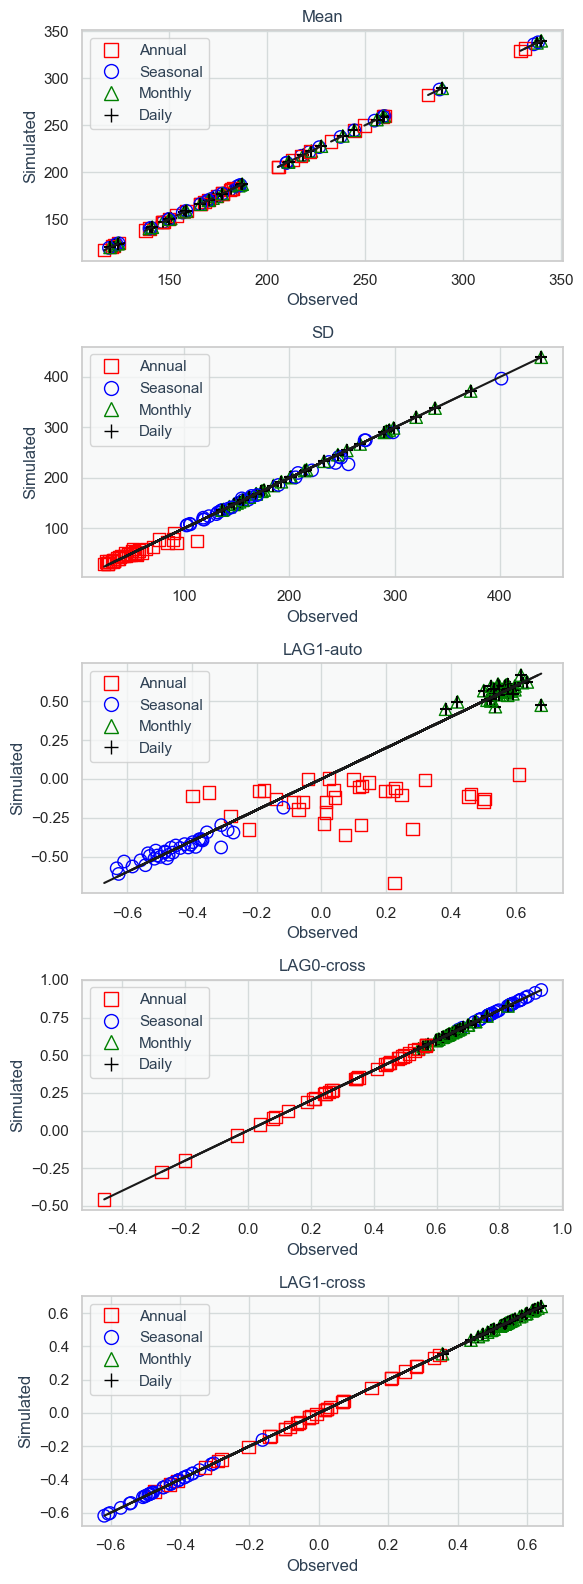

In [ ]:
# Plotting
fig, axs = plt.subplots(5, 1, figsize=(6, 16))

# Plot all data with corrected marker styling
for df in data_arr:
    observed = df['Precipitation']
    simulated = monthly_bias_correction(df['Precipitation'] , df['historical'])

    results = {'Mean': [], 'SD': [], 'LAG1-auto': [], 'LAG0-cross': [], 'LAG1-cross': []}

    for freq in frequencies:
        obs_agg = aggregate(observed, freq)
        sim_agg = aggregate(simulated, freq)
        stats = compute_stats(obs_agg, sim_agg)
        for key in results:
            results[key].append(stats[key])

    stat_names = ['Mean', 'SD', 'LAG1-auto', 'LAG0-cross', 'LAG1-cross']

    for i, stat in enumerate(stat_names):
        ax = axs[i]
        obs_vals = [x[0] for x in results[stat]]
        sim_vals = [x[1] for x in results[stat]]
        for j in range(len(frequencies)):
            # Corrected marker styling
            ax.scatter(
                obs_vals[j], sim_vals[j],
                marker=markers[j],
                edgecolor=colors[j],  # Always use color for edges
                facecolor='none' if markers[j] in ['s', 'o', '^'] else colors[j],  # Hollow for filled markers
                s=80
            )

        # Plot 45-degree diagonal (unchanged)
        min_val = min(min(obs_vals), min(sim_vals))
        max_val = max(max(obs_vals), max(sim_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'k-')

        ax.set_xlabel('Observed')
        ax.set_ylabel('Simulated')
        ax.set_title(stat)

# Create legend handles with corrected styling
handles = [
    plt.Line2D([], [],
               marker=markers[j],
               color=colors[j],
               markersize=10,
               markeredgecolor=colors[j],
               markerfacecolor='none' if markers[j] in ['s', 'o', '^'] else colors[j],
               linestyle='None',
               label=labels[j])
    for j in range(len(frequencies))
]

# Add legend to each subplot
for ax in axs:
    ax.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

In [89]:
from easy_mpl import taylor_plot

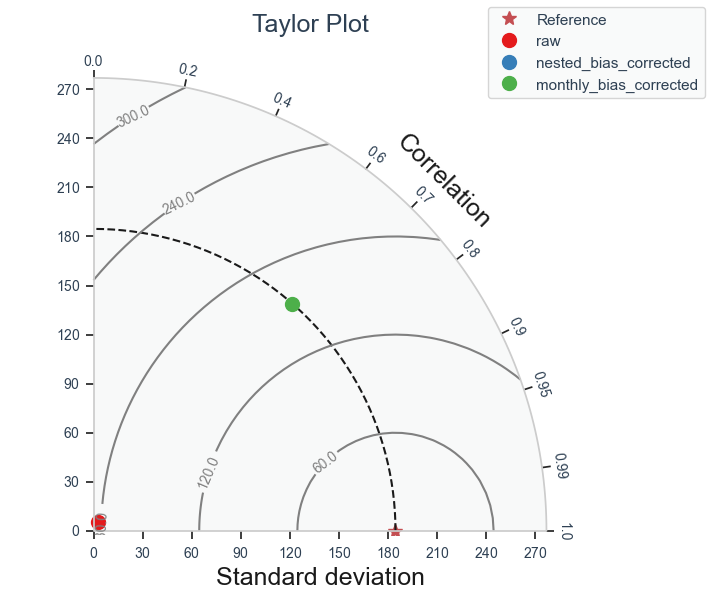

In [90]:
observations = data_arr[0]['Precipitation']

simulations = {
    'raw' : data_arr[0]['historical'],
    'nested_bias_corrected' : nested_bias_correction(data_arr[0]['Precipitation'] , data_arr[0]['historical']),
    'monthly_bias_corrected' : monthly_bias_correction(data_arr[0]['Precipitation'] , data_arr[0]['historical'])
}

_ = taylor_plot(observations=observations,
            simulations=simulations,
            title="Taylor Plot")

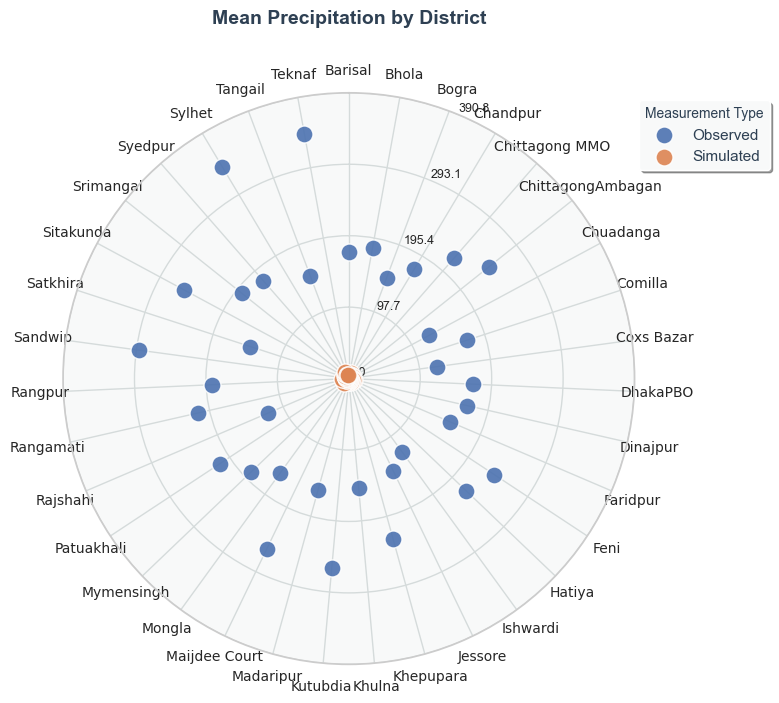

In [91]:
# Your data preparation
stations = [df['district'].iloc[0] for df in data_arr]
observed = [df['Precipitation'].mean() for df in data_arr]
simulated = [df['historical'].mean() for df in data_arr]

# Convert stations to angles
num_stations = len(stations)
angles = np.linspace(0, 2*np.pi, num_stations, endpoint=False).tolist()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)


# Plot values with modern markers
ax.scatter(angles, observed, s=150,
           edgecolor='white', linewidth=1, label='Observed',
           zorder=3, alpha=0.9, marker='o')

ax.scatter(angles, simulated, s=150,
           edgecolor='white', linewidth=1, label='Simulated',
           zorder=3, alpha=0.9)  # Square marker

# Axis customization
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(stations, fontsize=10, 
                  fontfamily='DejaVu Sans')

# Radial axis improvements
max_value = max(observed + simulated) * 1.15
ax.set_ylim(0, max_value)
ax.set_rgrids(np.linspace(0, max_value, 5), 
             labels=[f"{v:.1f}" for v in np.linspace(0, max_value, 5)],
             fontsize=9)

# Add elegant legend
legend = ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right',
                  title='Measurement Type',
                  frameon=True, shadow=True,
                  edgecolor='white', facecolor='#F8F9F9')
legend.get_title().set_fontsize(10)

# Add title and subtitle
plt.title('Mean Precipitation by District', 
         pad=50, fontsize=14, fontweight='semibold')

# Improve overall spacing
plt.tight_layout()
plt.subplots_adjust(top=0.85, right=0.8)

plt.show()

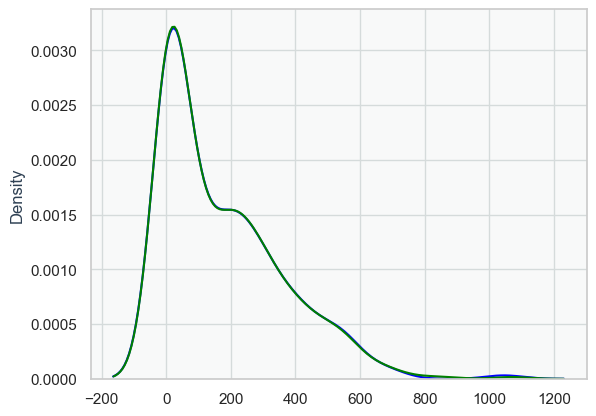

In [101]:
from scipy import interpolate

def quantile_mapping(obs_hist, sim_hist, sim_future, n_quantiles=100):
    """
    Perform quantile mapping bias correction
    
    Parameters:
    obs_hist (array): Observed historical data
    sim_hist (array): Simulated historical data
    sim_future (array): Simulated data to be corrected (can be future or same as sim_hist)
    n_quantiles (int): Number of quantiles to use
    
    Returns:
    array: Bias-corrected simulation data
    """
    # Compute quantiles for observed and simulated historical data
    obs_quantiles = np.quantile(obs_hist, np.linspace(0, 1, n_quantiles))
    sim_quantiles = np.quantile(sim_hist, np.linspace(0, 1, n_quantiles))
    
    # Create interpolation function for quantile mapping
    f = interpolate.interp1d(sim_quantiles, obs_quantiles, 
                            bounds_error=False,
                            fill_value=(obs_quantiles[0], obs_quantiles[-1]))
    
    # Apply correction to simulated data
    corrected = f(np.sort(sim_future))
    
    # Preserve original order
    return corrected[np.argsort(np.argsort(sim_future))]

# Example usage
if __name__ == "__main__":
    
    # Historical observed data
    obs_hist = data_arr[0]['Precipitation'].values
    
    # Historical simulated data (biased)
    sim_hist = data_arr[0]['historical'].values
    
    # Future/present simulated data to correct
    sim_future = data_arr[0]['historical'].values
    
    # Apply quantile mapping
    corrected = quantile_mapping(obs_hist, sim_hist, sim_future)
    
    
    sns.kdeplot(obs_hist, color='blue', label='Observed')
    # sns.kdeplot(sim_hist, color='red', label='Simulated')
    sns.kdeplot(corrected, color='green', label='Corrected')

C:\Users\Acer\AppData\Local\Temp\ipykernel_3800\196715004.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['corrected nqbc'] = nested_bias_correction(df['Precipitation'], df['corrected']).fillna(method='bfill')


Text(0.5, 1.0, 'Quantile Mapping Bias Correction')

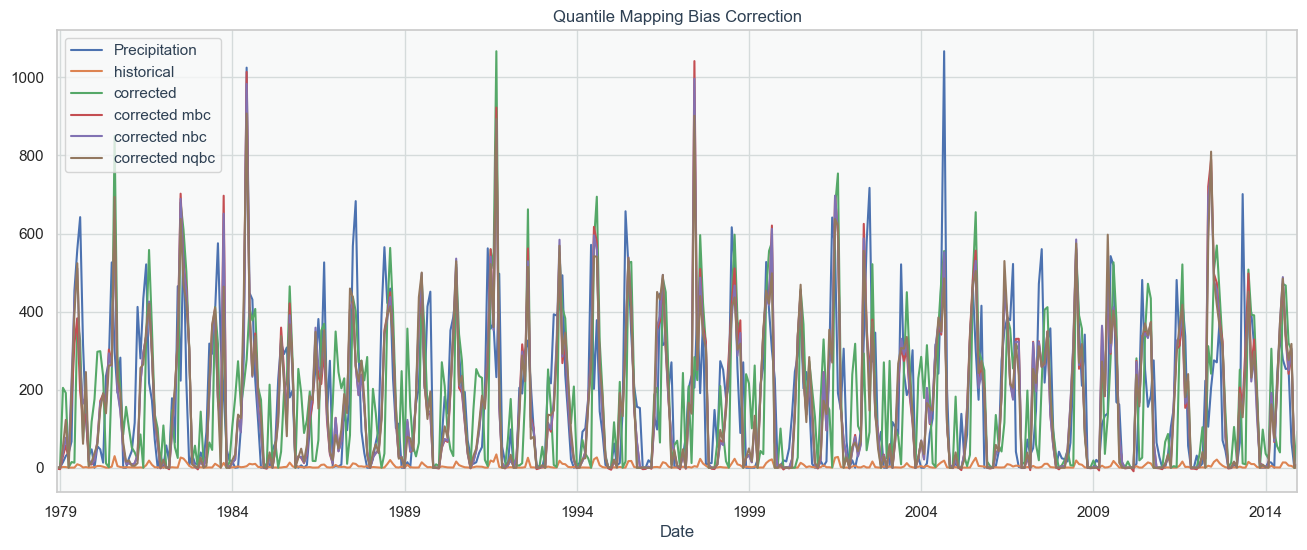

In [124]:
df = data_arr[0].copy()
df['corrected'] = corrected
df['corrected mbc'] = monthly_bias_correction(df['Precipitation'], df['historical'])
df['corrected nbc'] = nested_bias_correction(df['Precipitation'], df['historical'])
df['corrected nqbc'] = nested_bias_correction(df['Precipitation'], df['corrected']).fillna(method='bfill')
df[['Precipitation', 'historical', 'corrected', 'corrected mbc', 'corrected nbc', 'corrected nqbc']].plot(figsize=(16, 6))
plt.title('Quantile Mapping Bias Correction')

In [115]:
from sklearn.metrics import mean_squared_error, r2_score

print(mean_squared_error(df['Precipitation'], df['historical']))
print(mean_squared_error(df['Precipitation'], df['corrected']))
print(mean_squared_error(df['Precipitation'], df['corrected mbc']))
print(mean_squared_error(df['Precipitation'], df['corrected nbc'].fillna(method='bfill')))


61763.87138910521
40680.268614294815
23282.157579309947
22256.53349297531


C:\Users\Acer\AppData\Local\Temp\ipykernel_3800\1543584289.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  print(mean_squared_error(df['Precipitation'], df['corrected nbc'].fillna(method='bfill')))


<Axes: ylabel='Density'>

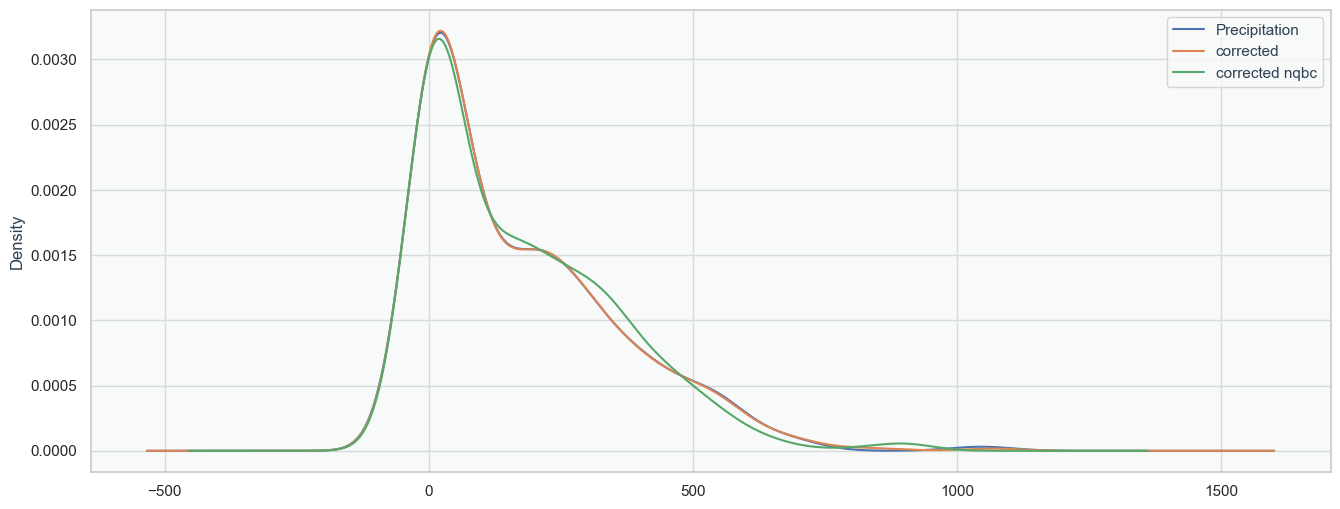

In [127]:
df[['Precipitation', 'corrected', 'corrected nqbc']].plot(figsize=(16, 6), kind='density')